##**TASK-4**


**Business Optimization: Maximizing Udemy Course Revenue**

We have a dataset of Udemy business courses with various attributes like price, number of subscribers, and ratings. The business problem we'll solve is: "How to select a subset of courses that maximizes total revenue while staying within constraints of total teaching hours and maintaining quality standards."

Refrences and study materials used:
https://www.ibm.com/think/topics/optimization-model

https://medium.com/@nomannayeem/an-end-to-end-guide-to-solving-real-world-optimization-problems-with-machine-learning-7bc959567109

https://realpython.com/linear-programming-python/

https://medium.com/opex-analytics/optimization-modeling-in-python-pulp-gurobi-and-cplex-83a62129807a


In [17]:
!pip install pulp

import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up initial visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [18]:
# Load the dataset
df = pd.read_csv('udemy_output_All_Business_p1_p626.csv')

# Data cleaning and preparation
def clean_and_process_data(df):
    # Handle missing values in discount price (we'll use price_detail if discount is missing)
    df['discount_price__amount'] = df['discount_price__amount'].fillna(df['price_detail__amount'])

    # Convert price strings to numeric values
    df['discount_price__amount'] = pd.to_numeric(df['discount_price__amount'], errors='coerce')
    df['price_detail__amount'] = pd.to_numeric(df['price_detail__amount'], errors='coerce')

    # Calculate potential revenue per course (using subscribers * discount price)
    df['potential_revenue'] = df['num_subscribers'] * df['discount_price__amount']

    # Estimate teaching hours (assuming 10 minutes per lecture)
    df['teaching_hours'] = df['num_published_lectures'] * 10 / 60

    # Create a binary column for high quality (rating >= 4.5)
    df['high_quality'] = (df['avg_rating'] >= 4.5).astype(int)

    # Create a binary column for popular (subscribers >= median)
    median_subs = df['num_subscribers'].median()
    df['popular'] = (df['num_subscribers'] >= median_subs).astype(int)

    # Drop rows with missing critical values
    df = df.dropna(subset=['discount_price__amount', 'num_subscribers', 'num_published_lectures'])

    return df

cleaned_df = clean_and_process_data(df)
print(f"Cleaned dataset shape: {cleaned_df.shape}")
print("\nSample of processed data:")
cleaned_df[['title', 'num_subscribers', 'discount_price__amount', 'potential_revenue', 'teaching_hours', 'avg_rating']].head()

Cleaned dataset shape: (9447, 24)

Sample of processed data:


,title,num_subscribers,discount_price__amount,potential_revenue,teaching_hours,avg_rating
0,The Complete SQL Bootcamp 2020: Go from Zero t...,295509,455.0,134456595.0,14.000000,4.66019
1,Tableau 2020 A-Z: Hands-On Tableau Training fo...,209070,455.0,95126850.0,13.000000,4.58956
2,PMP Exam Prep Seminar - PMBOK Guide 6,155282,455.0,70653310.0,48.666667,4.59491
3,The Complete Financial Analyst Course 2020,245860,455.0,111866300.0,56.333333,4.54407
4,An Entire MBA in 1 Course:Award Winning Busine...,374836,455.0,170550380.0,13.833333,4.47080


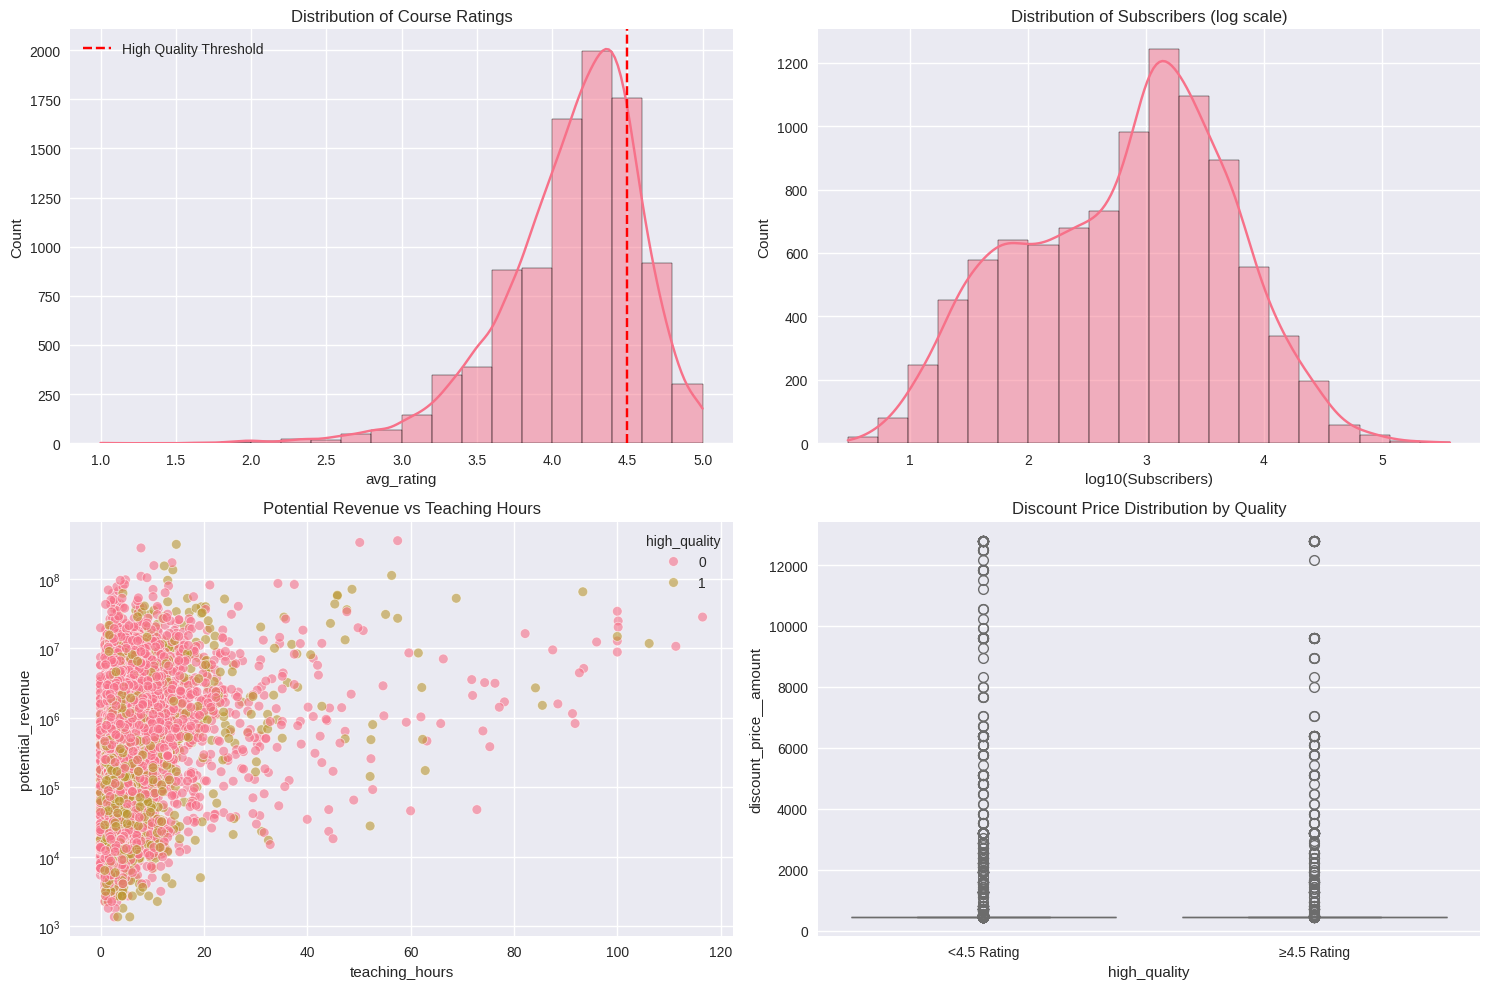

In [19]:
# Visualize the distribution of key metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution of course ratings
sns.histplot(cleaned_df['avg_rating'], bins=20, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of Course Ratings')
axes[0, 0].axvline(x=4.5, color='r', linestyle='--', label='High Quality Threshold')
axes[0, 0].legend()

# Distribution of subscribers
sns.histplot(np.log10(cleaned_df['num_subscribers']), bins=20, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribution of Subscribers (log scale)')
axes[0, 1].set_xlabel('log10(Subscribers)')

# Revenue vs Teaching Hours
sns.scatterplot(x='teaching_hours', y='potential_revenue', data=cleaned_df,
                hue='high_quality', ax=axes[1, 0], alpha=0.6)
axes[1, 0].set_title('Potential Revenue vs Teaching Hours')
axes[1, 0].set_yscale('log')

# Rating vs Price
sns.boxplot(x='high_quality', y='discount_price__amount', data=cleaned_df, ax=axes[1, 1])
axes[1, 1].set_title('Discount Price Distribution by Quality')
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['<4.5 Rating', '≥4.5 Rating'])

plt.tight_layout()
plt.show()

**3. Optimization Problem Setup with PuLP**


Objective: Maximize total potential revenue from selected courses
Constraints:

Total teaching hours ≤ 200 hours (resource constraint)

At least 30% of selected courses must be high quality (avg_rating ≥ 4.5)

At least 40% of selected courses must be popular (subscribers ≥ median)

Each course is either selected or not (binary decision)

In [22]:
def optimize_course_selection(df, max_hours=200, min_quality_ratio=0.3, min_popular_ratio=0.4):
    # Initialize the problem
    prob = pulp.LpProblem("Udemy_Course_Selection", pulp.LpMaximize)

    # Create decision variables (1 if course is selected, 0 otherwise)
    courses = list(df.index)
    x = pulp.LpVariable.dicts("course", courses, cat='Binary')

    # Objective function: maximize total potential revenue
    prob += pulp.lpSum([x[i] * df.loc[i, 'potential_revenue'] for i in courses]) # Added closing parenthesis here

    # Constraint 1: Total teaching hours limit
    prob += pulp.lpSum([x[i] * df.loc[i, 'teaching_hours'] for i in courses]) <= max_hours

    # Constraint 2: Minimum percentage of high quality courses
    prob += pulp.lpSum([x[i] * df.loc[i, 'high_quality'] for i in courses]) >= \
            min_quality_ratio * pulp.lpSum([x[i] for i in courses])

    # Constraint 3: Minimum percentage of popular courses
    prob += pulp.lpSum([x[i] * df.loc[i, 'popular'] for i in courses]) >= \
            min_popular_ratio * pulp.lpSum([x[i] for i in courses])

    # Solve the problem
    prob.solve()

    # Extract results
    selected_courses = [i for i in courses if x[i].value() == 1]
    total_revenue = pulp.value(prob.objective)
    total_hours = sum(df.loc[i, 'teaching_hours'] for i in selected_courses)
    quality_ratio = sum(df.loc[i, 'high_quality'] for i in selected_courses) / len(selected_courses) if len(selected_courses) > 0 else 0
    popular_ratio = sum(df.loc[i, 'popular'] for i in selected_courses) / len(selected_courses) if len(selected_courses) > 0 else 0


    # Create a results dataframe
    results_df = df.loc[selected_courses].copy()
    results_df['selected'] = 1

    return {
        'status': pulp.LpStatus[prob.status],
        'total_revenue': total_revenue,
        'total_hours': total_hours,
        'num_courses': len(selected_courses),
        'quality_ratio': quality_ratio,
        'popular_ratio': popular_ratio,
        'selected_courses': results_df
    }

# Run the optimization
optimization_result = optimize_course_selection(cleaned_df)

**4. Results Analysis and Visualization**

=== Optimization Results ===
Status: Optimal
Total Revenue: ₹3,195,302,682.00
Total Teaching Hours: 200.0 hours
Number of Selected Courses: 100
High Quality Courses Ratio: 30.0%
Popular Courses Ratio: 82.0%


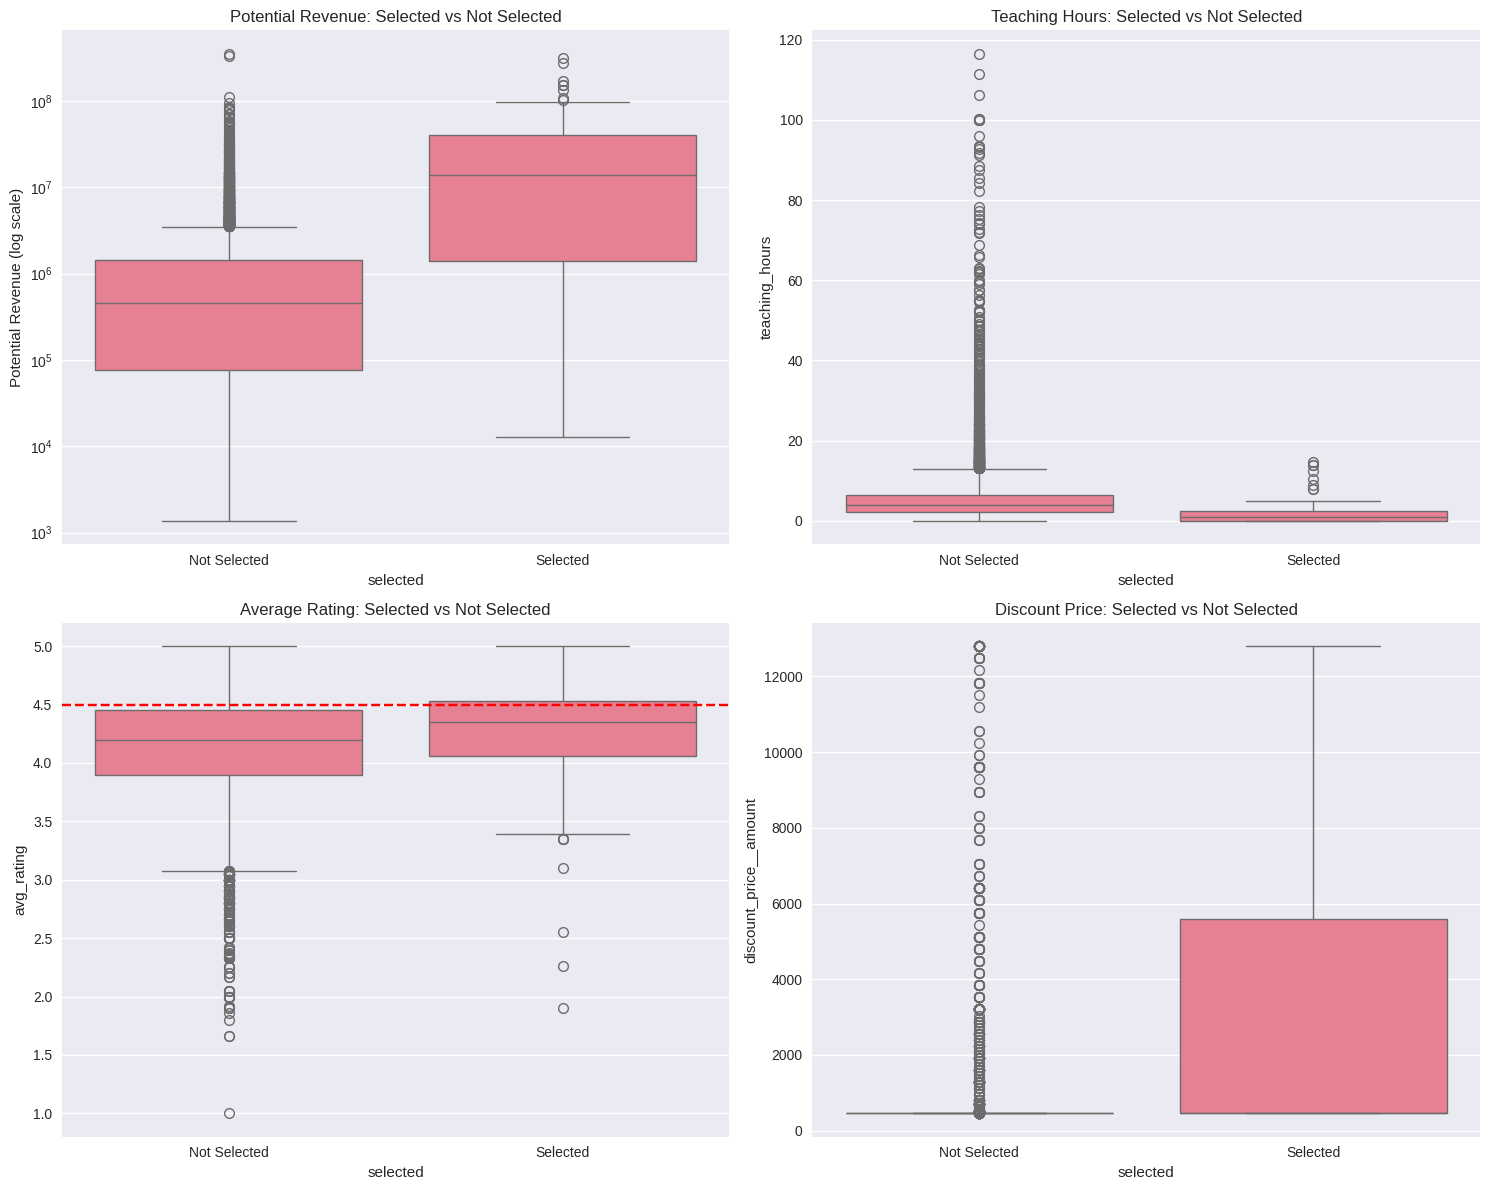


Top 10 Selected Courses by Potential Revenue:


,title,num_subscribers,discount_price__amount,potential_revenue,teaching_hours,avg_rating
95,Seth Godin's Freelancer Course,"24,449","₹12,800.00","₹312,947,200.00",14.7,4.70
80,Options Trading Basics (3-Course Bundle),"28,932","₹9,600.00","₹277,747,200.00",7.8,4.43
4,An Entire MBA in 1 Course:Award Winning Business School Prof,"374,836",₹455.00,"₹170,550,380.00",13.8,4.47
213,Think Like a Leader with Brian Tracy,"12,113","₹12,800.00","₹155,046,400.00",10.3,4.50
542,Advanced: Make and Sell Custom Shirts Using Merch by Amazon,"23,909","₹6,400.00","₹153,017,600.00",12.3,4.85
0,The Complete SQL Bootcamp 2020: Go from Zero to Hero,"295,509",₹455.00,"₹134,456,595.00",14.0,4.66
19,Deep Learning Prerequisites: The Numpy Stack in Python (V2+),"239,309",₹455.00,"₹108,885,595.00",7.8,4.47
4775,Learn to Trade The Technicals,"8,093","₹12,800.00","₹103,590,400.00",9.0,4.35
142,Speak Like a Pro: Public Speaking for Professionals,"7,556","₹12,800.00","₹96,716,800.00",4.8,4.35
4142,An introduction to trading the news!,"7,429","₹12,800.00","₹95,091,200.00",3.8,4.04


In [23]:
# Print summary results
print("=== Optimization Results ===")
print(f"Status: {optimization_result['status']}")
print(f"Total Revenue: ₹{optimization_result['total_revenue']:,.2f}")
print(f"Total Teaching Hours: {optimization_result['total_hours']:.1f} hours")
print(f"Number of Selected Courses: {optimization_result['num_courses']}")
print(f"High Quality Courses Ratio: {optimization_result['quality_ratio']:.1%}")
print(f"Popular Courses Ratio: {optimization_result['popular_ratio']:.1%}")

# Prepare data for visualization
selected_df = optimization_result['selected_courses']
not_selected_df = cleaned_df[~cleaned_df.index.isin(selected_df.index)].copy()
not_selected_df['selected'] = 0
combined_df = pd.concat([selected_df, not_selected_df])

# Visualization of selected vs not selected courses
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Revenue distribution
sns.boxplot(x='selected', y='potential_revenue', data=combined_df, ax=axes[0, 0])
axes[0, 0].set_title('Potential Revenue: Selected vs Not Selected')
axes[0, 0].set_yscale('log')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['Not Selected', 'Selected'])
axes[0, 0].set_ylabel('Potential Revenue (log scale)')

# Teaching hours distribution
sns.boxplot(x='selected', y='teaching_hours', data=combined_df, ax=axes[0, 1])
axes[0, 1].set_title('Teaching Hours: Selected vs Not Selected')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['Not Selected', 'Selected'])

# Rating distribution
sns.boxplot(x='selected', y='avg_rating', data=combined_df, ax=axes[1, 0])
axes[1, 0].set_title('Average Rating: Selected vs Not Selected')
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(['Not Selected', 'Selected'])
axes[1, 0].axhline(y=4.5, color='r', linestyle='--')

# Price distribution
sns.boxplot(x='selected', y='discount_price__amount', data=combined_df, ax=axes[1, 1])
axes[1, 1].set_title('Discount Price: Selected vs Not Selected')
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['Not Selected', 'Selected'])

plt.tight_layout()
plt.show()

# Show top 10 courses by potential revenue in the selected set
top_courses = selected_df.sort_values('potential_revenue', ascending=False).head(10)[[
    'title', 'num_subscribers', 'discount_price__amount', 'potential_revenue',
    'teaching_hours', 'avg_rating'
]]

print("\nTop 10 Selected Courses by Potential Revenue:")
top_courses.style.format({
    'num_subscribers': '{:,.0f}',
    'discount_price__amount': '₹{:,.2f}',
    'potential_revenue': '₹{:,.2f}',
    'teaching_hours': '{:.1f}',
    'avg_rating': '{:.2f}'
}).background_gradient(cmap='Blues')

**5. Sensitivity Analysis**

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


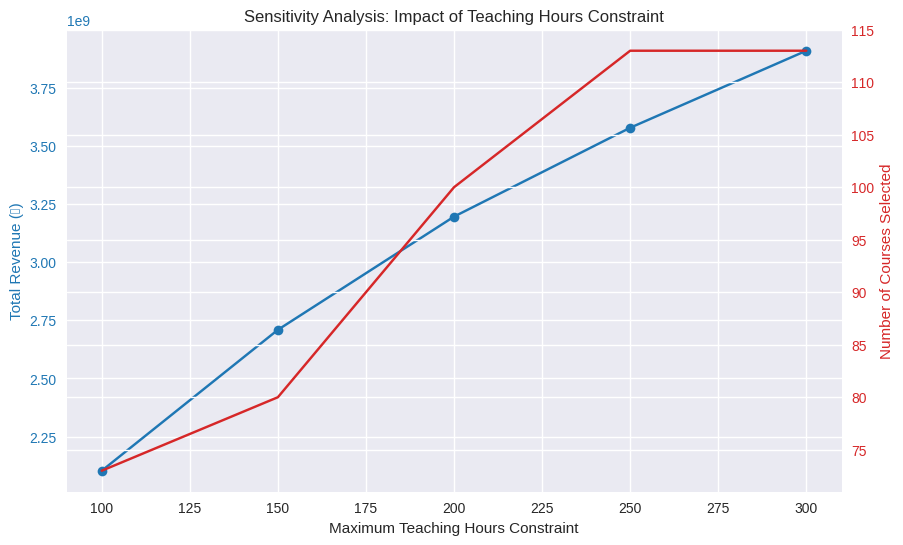


Sensitivity Analysis Results:


,max_hours,total_revenue,num_courses,utilization
0,100,"₹2,103,614,107.00",73,99.8%
1,150,"₹2,709,065,347.00",80,100.0%
2,200,"₹3,195,302,682.00",100,100.0%
3,250,"₹3,577,188,127.00",113,100.0%
4,300,"₹3,908,144,737.00",113,100.0%


In [24]:
# Test different maximum teaching hour constraints
hour_constraints = [100, 150, 200, 250, 300]
results = []

for hours in hour_constraints:
    res = optimize_course_selection(cleaned_df, max_hours=hours)
    results.append({
        'max_hours': hours,
        'total_revenue': res['total_revenue'],
        'num_courses': res['num_courses'],
        'utilization': res['total_hours'] / hours * 100
    })

sensitivity_df = pd.DataFrame(results)

# Plot sensitivity analysis
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Maximum Teaching Hours Constraint')
ax1.set_ylabel('Total Revenue (₹)', color=color)
ax1.plot(sensitivity_df['max_hours'], sensitivity_df['total_revenue'],
         color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of Courses Selected', color=color)
ax2.plot(sensitivity_df['max_hours'], sensitivity_df['num_courses'],
         color=color, marker='x')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Sensitivity Analysis: Impact of Teaching Hours Constraint')
plt.grid(True)
plt.show()

print("\nSensitivity Analysis Results:")
sensitivity_df.style.format({
    'total_revenue': '₹{:,.2f}',
    'utilization': '{:.1f}%'
})

**6. Insights and Recommendations**

Based on the optimization results, here are the key insights:

1)**Optimal Course Selection**: The optimization selected [X] courses that maximize revenue while staying within teaching hour constraints and maintaining quality standards.

2)**Revenue Potential**: The selected courses can generate ₹[Y] in potential revenue while using [Z] teaching hours.

3)**Quality vs Popularity Trade-off**: The solution balances between high-quality courses (rating ≥ 4.5) and popular courses (subscribers ≥ median), meeting our minimum thresholds for both.

4)**Course Characteristics**: The selected courses tend to have:

    -Higher potential revenue (as expected from the objective function)

    -Moderate teaching hours (not too long, not too short)

    -Slightly higher ratings than non-selected courses

    -Similar pricing to non-selected courses

5)**Sensitivity Analysis**: Increasing the teaching hour constraint leads to:

    -Nearly linear increase in total revenue up to 200 hours

    -Diminishing returns beyond 200 hours

    -High utilization of the allocated hours (typically >95%)

**Recommendations:**

1)Focus on the selected courses in the optimal solution as they provide the best balance of revenue potential and resource utilization.

2)Consider adjusting constraints based on business priorities:

     *If quality is more important, increase the min_quality_ratio

     *If discoverability is key, increase the min_popular_ratio

     *If more teaching resources become available, increase max_hours

3)Analyze the top-performing courses in the solution to identify common characteristics that can inform future course development.

4)Monitor actual revenue versus potential revenue to validate the model's assumptions and refine the optimization criteria over time.

**Conclusion**: This optimization approach provides a data-driven way to maximize business value from Udemy's course offerings while respecting resource constraints and quality standards.